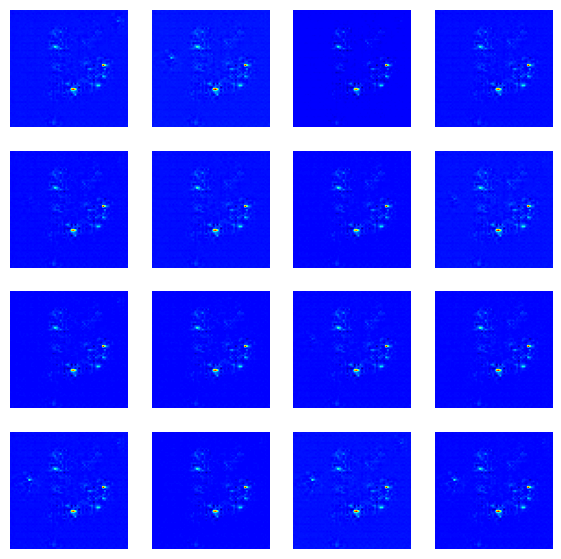

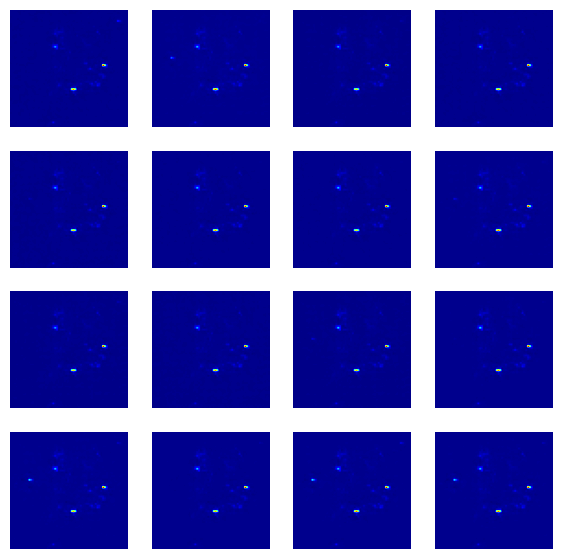

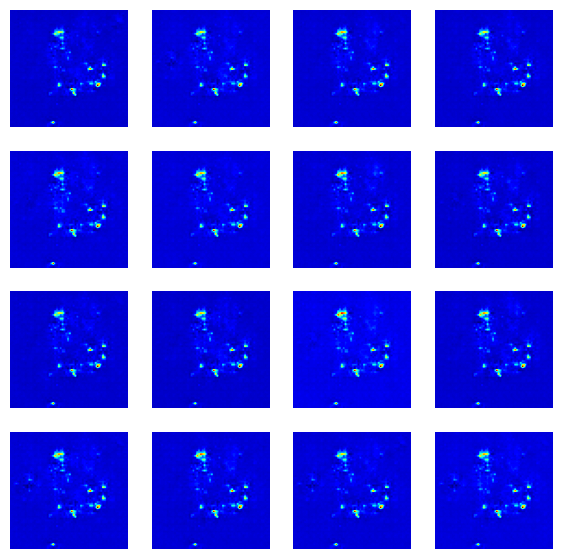

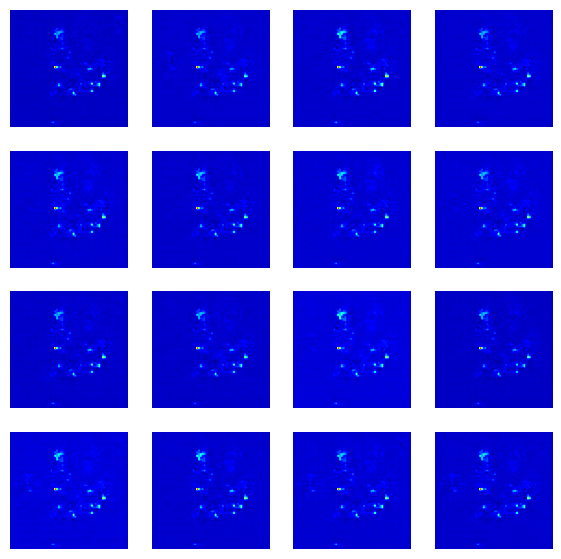

In [1]:
import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())
path = '/home/workspace'
data_path = os.path.join(path,'cmaqProjectdata')
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
BATCH_SIZE = 8
EPOCH = 1
shuffle_buffer_size = 80
train_set_len = 80
LAMBDA = 100

INPUT_SHAPE = [119]
OUTPUT_CHANNELS = 1
### 데이터셋
avg_conc_path_list = glob(os.path.join(data_path,"연평균자료","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

avg_ems_path_list = glob(os.path.join(data_path,"연평균자료","emission","*"))
avg_ems_path_info_df = pd.DataFrame()
avg_ems_path_info_df.loc[:,'path_ems'] = avg_ems_path_list
avg_ems_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_ems_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"연평균자료","02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, avg_ems_path_info_df, how='left', on='Run')
merged_info_df = pd.merge(merged_info_df, cont_matrix, how='left', on='Run')

target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]


smoke_list = [Dataset(path, 'r') for path in merged_info_df.path_ems.tolist()]
smoke_chem_list = ['SO2', 'PM2_5', 'NOx', 'VOCs', 'NH3', 'CO']
smoke_val_list = []
for i in smoke_chem_list:
    smoke_arr_i = np.concatenate([np.array(Dataset(path, 'r').variables[i][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path_ems.tolist()])[:,:,:,None]
    smoke_val_list.append(smoke_arr_i)

smoke_arr = np.concatenate(smoke_val_list, axis = 3)
smoke_arr.shape, target_arr.shape
input_cols = list(set(merged_info_df.columns) - set(['path','Run','path_ems']))

train_input = merged_info_df.loc[:,input_cols].values[:train_set_len]
test_input = merged_info_df.loc[:,input_cols].values[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_smoke = smoke_arr[:train_set_len]
test_smoke = smoke_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)
train_smoke_ds = tf.data.Dataset.from_tensor_slices(train_smoke)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)
test_smoke_ds = tf.data.Dataset.from_tensor_slices(test_smoke)

train_ds = tf.data.Dataset.zip((train_input_ds, train_smoke_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_smoke_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)

# train_ds = ds.take(train_set_len) 
# test_ds = ds.skip(train_set_len)
### 제너레이션 모델
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16*16*256, use_bias=False, input_shape=(100 + 119,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # model.add(tf.keras.layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.Conv2DTranspose(6, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # 실제 값 스케일로 예측하기 위해 활성화함수x
    assert model.output_shape == (None, 64, 64, 6)

    return model
generator = make_generator_model()

noise = tf.random.normal([1, 100 + 119])  ## 여기서 119는 컨트롤매트릭스차원
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 6]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1)) # 바이너리 크로스엔트로피 구할 떄 로짓으로 구하므로 활성화함수x

    return model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 모델 저장하고싶을 때 체크하자

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)

noise_dim = 100
num_examples_to_generate = 16

# 베이스시드로 고정 (시나리오1의 컨트롤 매트릭스 + 노이즈로 구성)
noise_std = 0.3

noise = tf.random.normal([num_examples_to_generate, noise_dim],mean = 1, stddev = noise_std)
base_senario = tf.random.normal([num_examples_to_generate, 119])
base_senario = tf.ones_like(base_senario)
seed = tf.concat([noise, base_senario], axis = 1)
import time
from IPython import display
@tf.function
def train_step(images, conditional_input):
    noise = tf.random.normal([BATCH_SIZE, noise_dim],mean = 1, stddev = noise_std)
    noised_input = tf.concat([noise, tf.cast(conditional_input, tf.float32)], axis = 1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noised_input, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output, generated_images, images)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss



import matplotlib
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7,7))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')
# os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_1_checkpoint")
  # plt.savefig(os.path.join(proj_path,'plots','gen_plots','NOx_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

  fig = plt.figure(figsize=(7,7))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 1][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  # plt.savefig(os.path.join(proj_path,'plots','gen_plots','SO2_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

  fig = plt.figure(figsize=(7,7))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 2][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  # plt.savefig(os.path.join(proj_path,'plots','gen_plots','VOCs_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

  fig = plt.figure(figsize=(7,7))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 3][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  # plt.savefig(os.path.join(proj_path,'plots','gen_plots','NH3_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

def train(dataset, epochs):
  gen_l_list = []
  disc_l_list = []
  for epoch in range(epochs):
    start = time.time()

    for control_mt_batch, image_batch,_ in dataset:
      gen_l, disc_l = train_step(image_batch, control_mt_batch)
      gen_l_list.append(gen_l)
      disc_l_list.append(disc_l)

    # GIF를 위한 이미지를 생성.,
    if (epoch + 1) % 100 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)

    #에포크가 지날 때마다 모델을 저장.
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  return gen_l_list, disc_l_list

gen_loss_list, disc_loss_list = train(train_ds, 500)


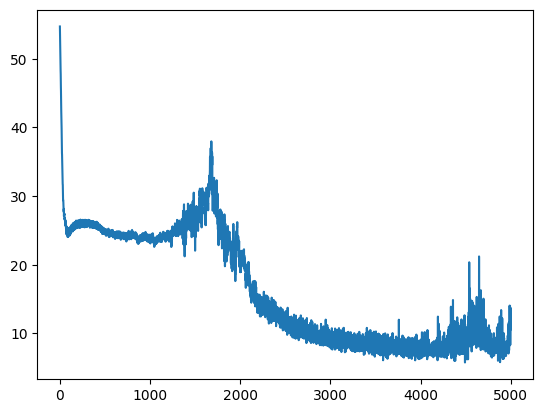

In [2]:
plt.plot(gen_loss_list)

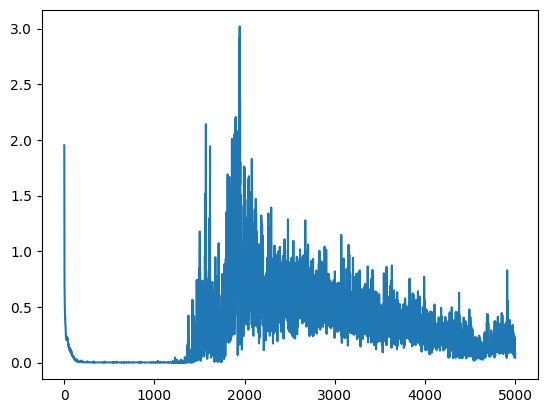

In [3]:
plt.plot(disc_loss_list)

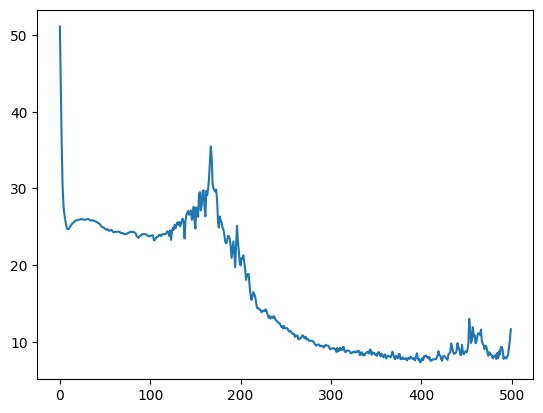

In [8]:
len = 10
j = 0
result_list = []
for i in range(5000):
    result_list.append(tf.reduce_mean(gen_loss_list[10*i:10*(i+1)]))
    # j += (i+1)*len

# gen_loss_list
plt.plot(result_list)

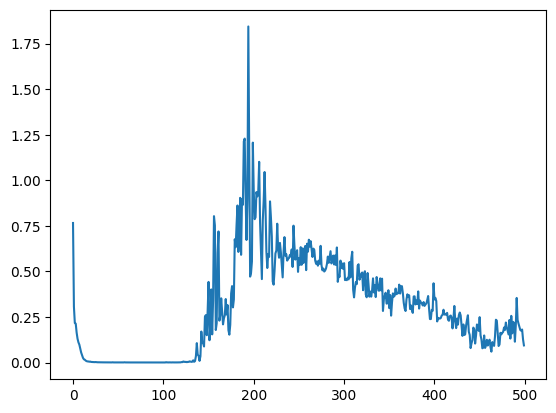

In [9]:
len = 10
j = 0
result_list2 = []
for i in range(5000):
    result_list2.append(tf.reduce_mean(disc_loss_list[10*i:10*(i+1)]))
    # j += (i+1)*len

# gen_loss_list
plt.plot(result_list2)

* test_ds, performance

In [12]:
for batch_test, smoke_batch_test,_ in test_ds:
    break

In [15]:
noise = tf.random.normal([BATCH_SIZE, noise_dim],mean = 1, stddev = noise_std)
noised_input = tf.concat([noise, tf.cast(batch_test, tf.float32)], axis = 1)
generated_images = generator(noised_input, training=True)

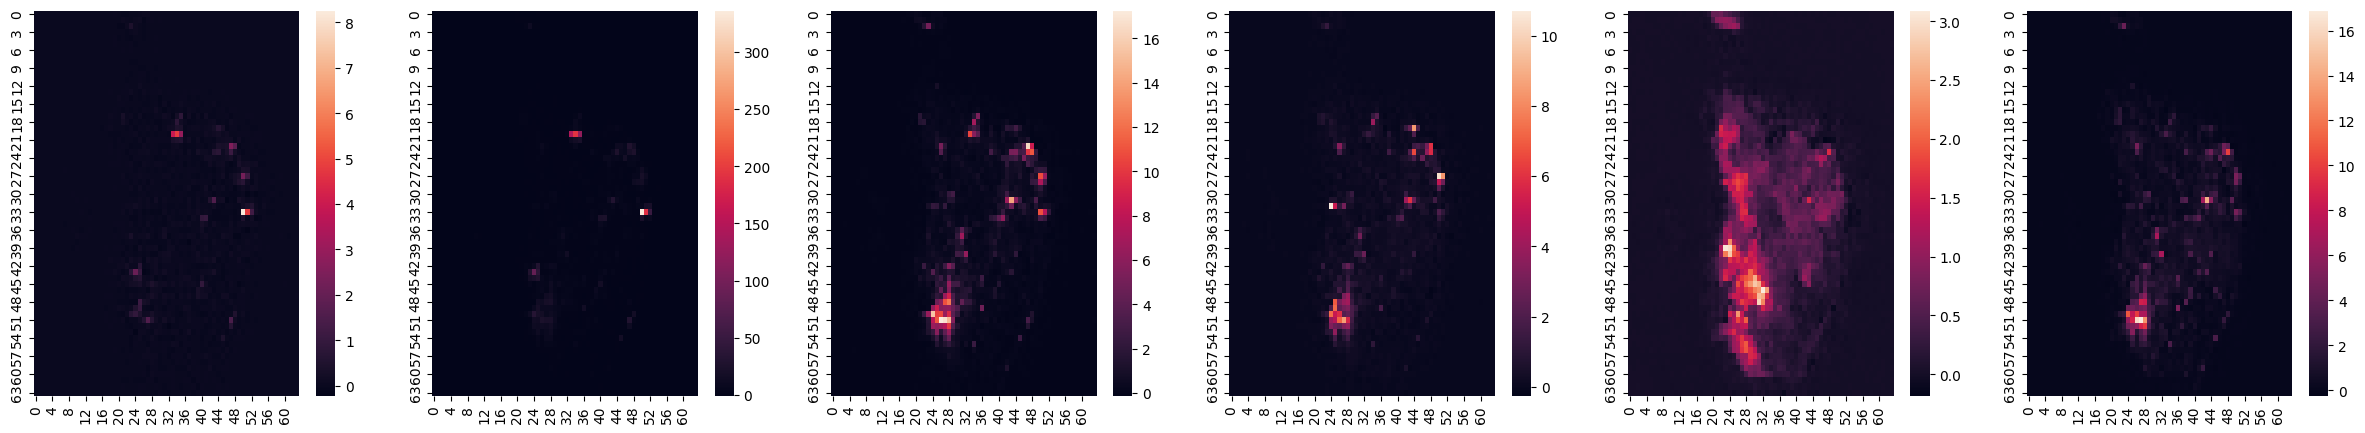

In [23]:
fig = plt.figure(figsize=(30,5))
for i in range(6):
    plt.subplot(1,6,i+1)
    sns.heatmap(generated_images[0][:,:,i])

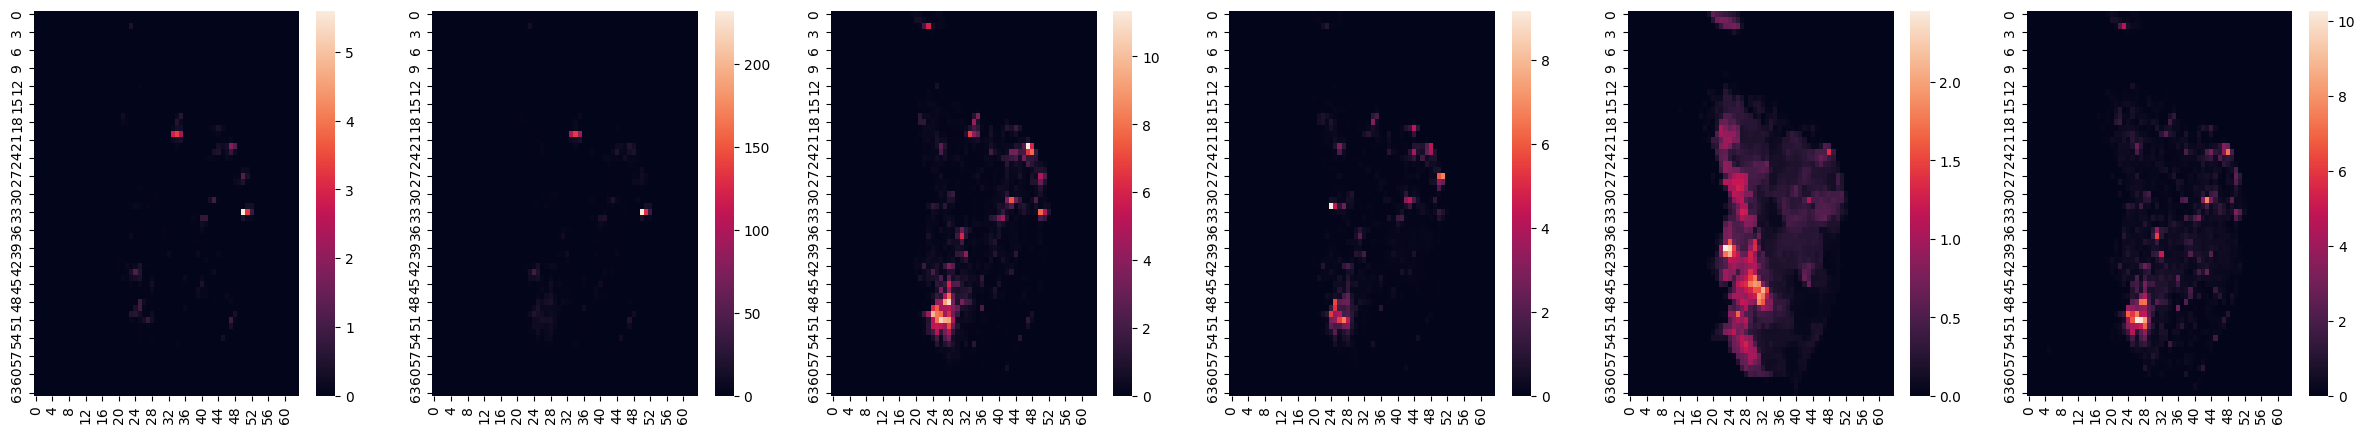

In [24]:
fig = plt.figure(figsize=(30,5))
for i in range(6):
    plt.subplot(1,6,i+1)
    sns.heatmap(smoke_batch_test[0][:,:,i])

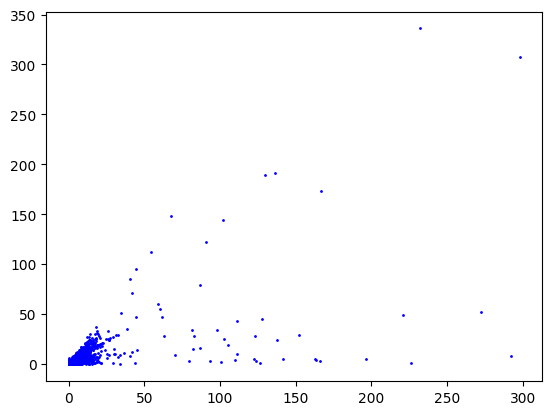

In [28]:
plt.plot(smoke_batch_test.numpy().reshape(-1),generated_images.numpy().reshape(-1),'bo', markersize=1)

* train_ds, performance

In [29]:
for batch_train, smoke_batch_train,_ in train_ds:
    break

In [36]:
noise = tf.random.normal([BATCH_SIZE, noise_dim],mean = 1, stddev = noise_std)
noised_input = tf.concat([noise, tf.cast(batch_train, tf.float32)], axis = 1)
generated_images = generator(noised_input, training=True)

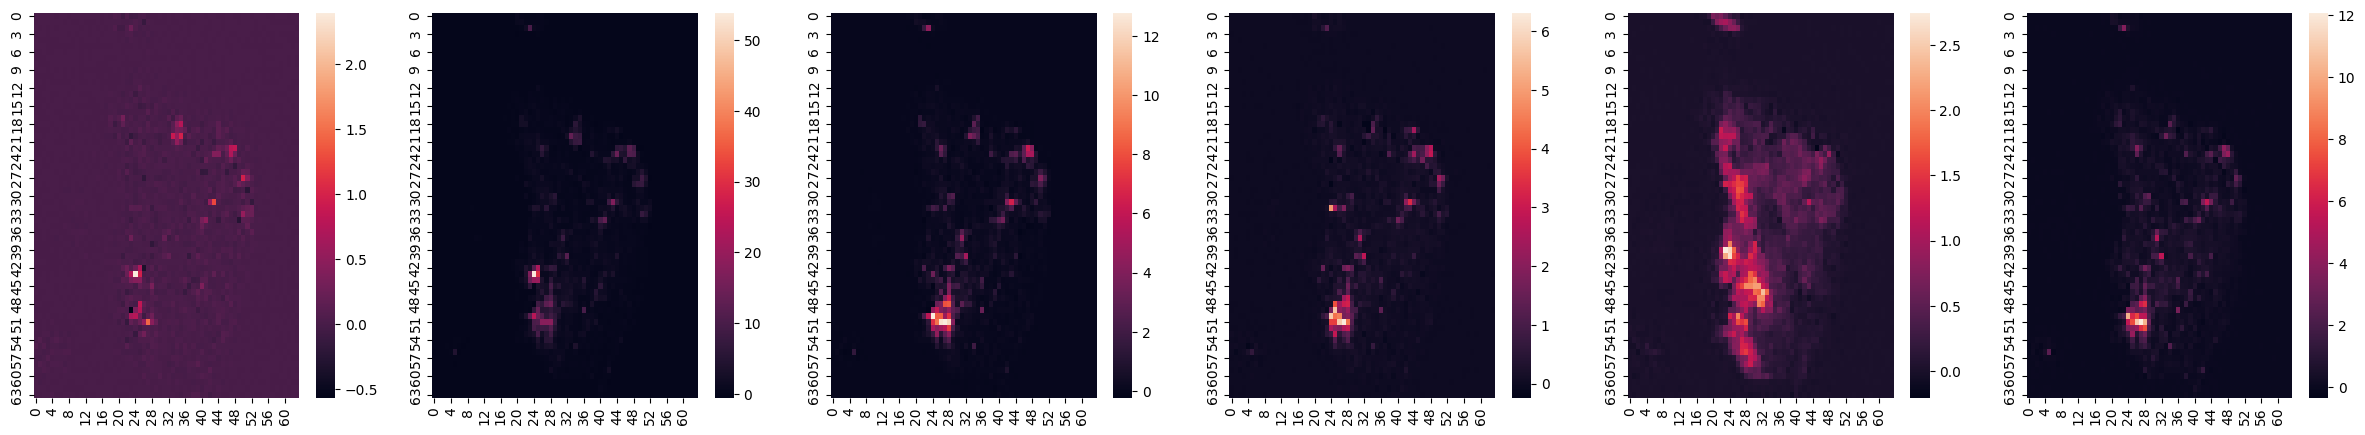

In [37]:
fig = plt.figure(figsize=(30,5))
for i in range(6):
    plt.subplot(1,6,i+1)
    sns.heatmap(generated_images[4][:,:,i])

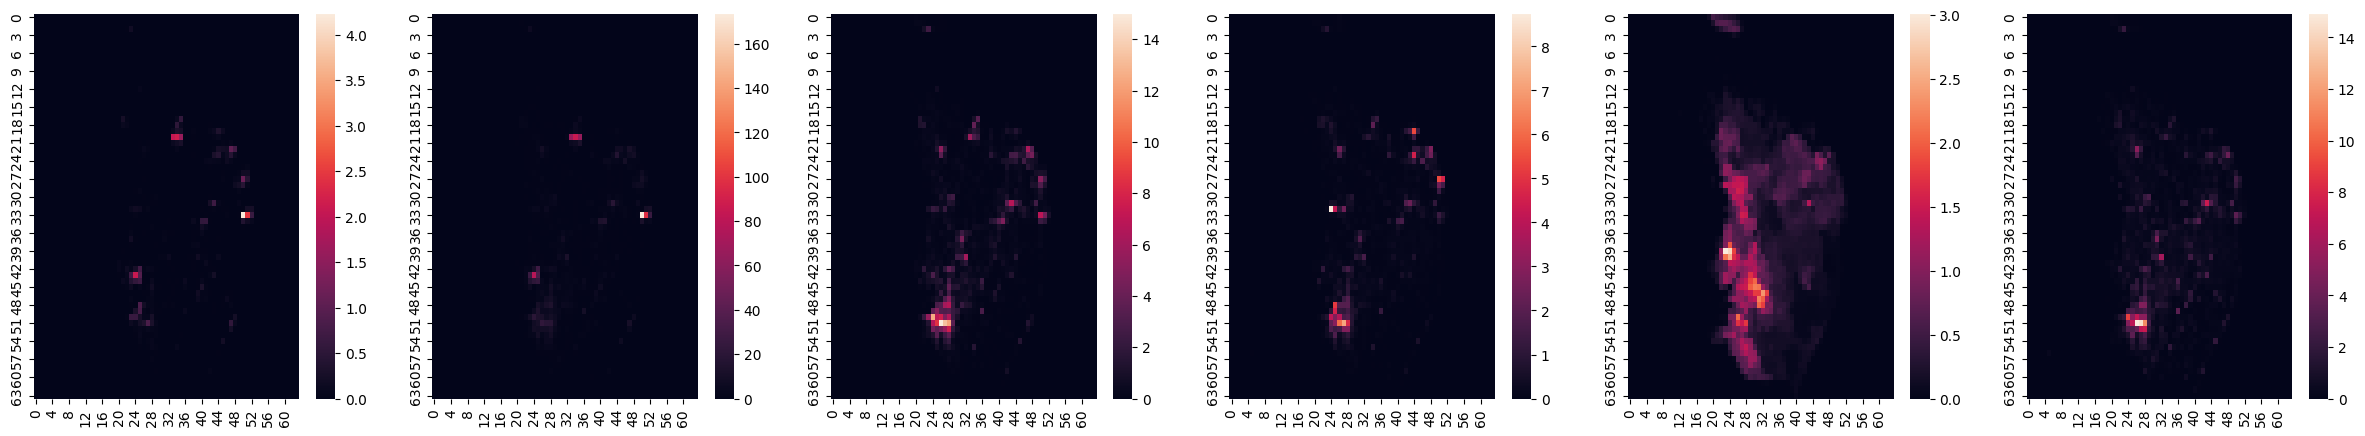

In [38]:
fig = plt.figure(figsize=(30,5))
for i in range(6):
    plt.subplot(1,6,i+1)
    sns.heatmap(smoke_batch_train[4][:,:,i])

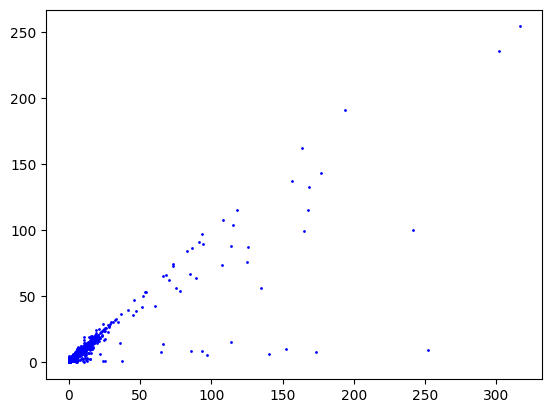

In [39]:
plt.plot(smoke_batch_train.numpy().reshape(-1),generated_images.numpy().reshape(-1),'bo', markersize=1)